# 3.03 Stable Isotope Calculation Templates - Fe isotopes
*Simon Matthews (simonm@hi.is), July 2024*

---

This notebook is intended to be a starting point for setting up calculations of stable Fe isotope fractionation during multi-component mantle melting. See other templates to set up a different set of lithologies, if you want to calculate trace elements, or to model other stable isotope systems.

The calculations here loosely follow those outlined in Williams et al. (2021), and further explored in Soderman et al. (2021), except for explicitly considering magma aggregation.

Though I have added some description of each step, to find a more comprehensive account of why the calculation is structured the way it is see the pyMelt documentation and tutorials.

## 1. Preliminaries

Import required packages:

In [1]:
import pyMelt as m
import numpy as np
import matplotlib.pyplot as plt

Retrieve a lherzolite and pyroxenite lithology. In this case, the parameterisations of KLB1 and KG1 given in Matthews et al. (2021). KLB1 represents fertile lherzolite mantle, and KG1 represents a mixture between a MORB-like eclogite composition and lherzolite. These lithologies have thermocalc phase diagrams attached.

In [2]:
lz = m.lithologies.matthews.klb1()
px = m.lithologies.matthews.kg1()

Create a mantle object with 10% pyroxenite:

In [9]:
mantle = m.mantle([lz, px], [0.9, 0.1], ['lz', 'px'])

## 2. Melt the mantle

Melt the mantle assuming a $T_p$=1330˚C to produce a melting column of incremental melts.

In [10]:
column = mantle.adiabaticMelt(1330.0)

We can visualise the results of the melting calculation:

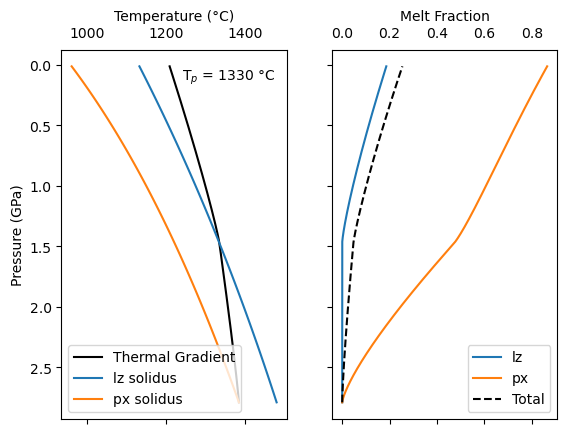

In [11]:
f, a = column.plot()

## 3. Calculate chemical properties of the melting column
First, calculate the residuum mineralogy at each step. The mineral proportions are extracted from the phase diagram attached to each lithology. This is required by the Fe-isotope calculations:

In [6]:
column.calculateMineralProportions()

We can see the results by plotting them directly:

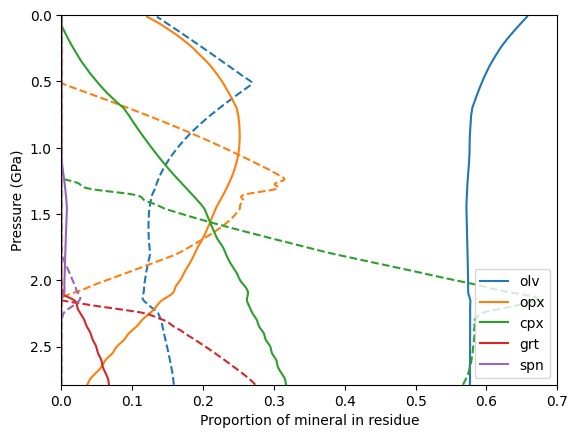

In [7]:
f, a = plt.subplots()

colours = {'olv': 'C0', 'opx': 'C1', 'cpx': 'C2', 'grt': 'C3', 'spn':'C4'}

for min in ['olv', 'opx', 'cpx', 'grt','spn']:
    a.plot(column.composition['lz'][min], column.P, c=colours[min], label=min)
    a.plot(column.composition['px'][min], column.P, c=colours[min], ls='--')

a.legend(loc='lower right')
a.set_xlabel('Proportion of mineral in residue')
a.set_ylabel('Pressure (GPa)')

a.set_xlim(0, 0.7)
a.set_ylim(np.nanmax(column.P), 0.0)

plt.show()

The final information needed before we can calculate stable isotopes is the Fe<sup>2+</sup> and Fe<sup>3+</sup> content of the melt and each mineral phase at each step. This is information which is looked up from the phase diagram attached to the lithology.

In [7]:
column.calculateMajorOxides()

NameError: name 'column' is not defined

Again, we can visualise these results. *Note that when a phase is not present, the oxide concentration should be set to 0.0, but numerical imprecision in the phaseDiagram interpolation may make this imperfect*.

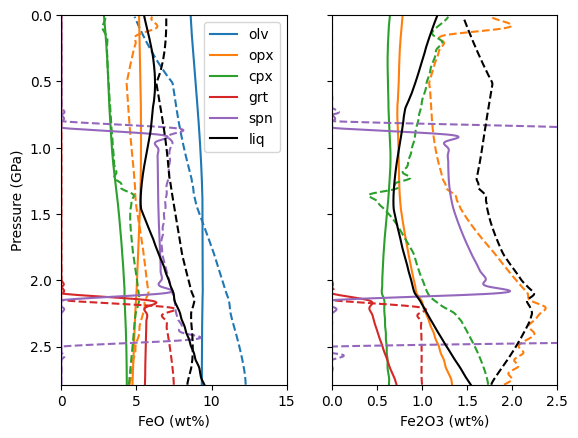

In [9]:
f, a = plt.subplots(1, 2, sharey='row')

colours = {'olv': 'C0', 'opx': 'C1', 'cpx': 'C2', 'grt': 'C3', 'spn':'C4', 'liq': 'k'}

for min in ['olv', 'opx', 'cpx', 'grt', 'spn', 'liq']:
    a[0].plot(column.composition['lz'][min+'_FeO'], column.P,
              c=colours[min], label=min)
    a[0].plot(column.composition['px'][min+'_FeO'], column.P, 
              c=colours[min], ls='--')
    a[1].plot(column.composition['lz'][min+'_Fe2O3'], column.P,
              c=colours[min])
    a[1].plot(column.composition['px'][min+'_Fe2O3'], column.P, 
              c=colours[min], ls='--')
    
a[0].set_ylim(np.nanmax(column.P), 0.0)
a[0].set_xlim(0, 15)
a[1].set_xlim(0, 2.5)

a[0].set_ylabel('Pressure (GPa)')
a[0].set_xlabel('FeO (wt%)')
a[1].set_xlabel('Fe2O3 (wt%)')

a[0].legend()

plt.show()

All of these results are now embedded in the melting column object, and so they can now be used by the stable isotope calculations.

## 4. Setup stable isotope calculations

A mineral-melt fractionation factor must be defined for each mineral, as well as the Fe isotope ratio of solid lithology before melting. Following the logic outlined by Sossi et al., we can estimate the fractionation factor based on the charge, coordination number, and bond length for each mineral site. The information about mineral sites that Fe is sitting on at each increment of the calculation is contained in the phase diagram attached to each lithology (if calculated from the MELTS or THERMOCALC models).

We must define a function that will use these parameters to derived the fractionation factor:

In [10]:
def olv_ff_56_54(state, phaseDiagram):
    xm1 = phaseDiagram('olv_xFeM1', state)
    xm2 = phaseDiagram('olv_xFeM2', state)
    rm1 = 2.16 # Site radius M1
    rm2 = 2.19 # Site radius M2
    cm1 = 6 # Coordination number M1
    cm2 = 6 # Coordination number M2
    Ocm1 = 4 # Coordination number of Oxygen M1
    Ocm2 = 4 # Coordination number of Oxygen M1
    vm1 = 2 # Charge on M1
    vm2 = 2 # Charge on M2
    q = 1.602e-19
    cc = 9e9
    B = 12
    I = 0.36
    KT_Melt_Fe2=199
    KT_Melt_Fe3=351
    DeltaFactor = 2904 # For 56/54
    # DeltaFactor = 4284 # For 57/54

    if xm1 + xm2 == 0:
        return 0.0

    KTm1 = 0.25 * (- vm1) / cm1 * 2 / Ocm1 * q**2 * cc * (1-B) / (rm1 * 1e-10)**3 * cm1 / I # This could be precalculated to speed up the calculation
    KTm2 = 0.25 * (- vm2) / cm2 * 2 / Ocm2 * q**2 * cc * (1-B) / (rm2 * 1e-10)**3 * cm2 / I # This could be precalculated to speed up the calculation

    KT = (xm1 * KTm1 + xm2 * KTm2) / (xm1 + xm2)

    liq_xFe3FeT = state['liq_Fe2O3'] / 79.8435 / (state['liq_FeO'] / 71.844 + state['liq_Fe2O3'] / 79.8435)

    KTliq = liq_xFe3FeT * (KT_Melt_Fe3 - KT_Melt_Fe2) + KT_Melt_Fe2

    ff = (KT - KTliq) * DeltaFactor / (state['T'] + 273.15)**2 
    
    return ff

def spn_ff_56_54(state, phaseDiagram):
    xmFe2 = phaseDiagram('spn_xFeM', state) * 2
    xtFe2 = phaseDiagram('spn_xFeT', state)
    xmFe3 = phaseDiagram('spn_xFe3M', state) * 2
    xtFe3 = phaseDiagram('spn_xFe3T', state)
    rmfe2 = 2.15 # Site radius M for Fe2+
    rtfe2 = 2.0 # Site radius T for Fe2+
    rmfe3 = 2.025 # Site radius M for Fe3+
    rtfe3 = 1.875 # Site radius T for Fe3+
    cm = 6 # Coordination number M1
    ct = 4 # Coordination number M2
    Ocm = 4 # Coordination number of Oxygen M1
    Oct = 4 # Coordination number of Oxygen M1
    q = 1.602e-19
    cc = 9e9
    B = 12
    I = 0.36
    KT_Melt_Fe2=199
    KT_Melt_Fe3=351
    DeltaFactor = 2904 # For 56/54
    # DeltaFactor = 4284 # For 57/54

    if xmFe2 + xmFe3 + xtFe2 + xtFe3 == 0:
        return 0.0

    KTmFe2 = 0.25 * (- 2) / cm * 2 / Ocm * q**2 * cc * (1-B) / (rmfe2 * 1e-10)**3 * cm / I # This could be precalculated to speed up the calculation
    KTtFe2 = 0.25 * (- 2) / ct * 2 / Oct * q**2 * cc * (1-B) / (rtfe2 * 1e-10)**3 * ct / I # This could be precalculated to speed up the calculation
    KTmFe3 = 0.25 * (- 3) / cm * 2 / Ocm * q**2 * cc * (1-B) / (rmfe3 * 1e-10)**3 * cm / I # This could be precalculated to speed up the calculation
    KTtFe3 = 0.25 * (- 3) / ct * 2 / Oct * q**2 * cc * (1-B) / (rtfe3 * 1e-10)**3 * ct / I # This could be precalculated to speed up the calculation

    KT = (xmFe2 * KTmFe2 + xtFe2 * KTtFe2 + xmFe3 * KTmFe3 + xtFe3 * KTtFe3) / (xmFe2 + xmFe3 + xtFe2 + xtFe3)

    liq_xFe3FeT = state['liq_Fe2O3'] / 79.8435 / (state['liq_FeO'] / 71.844 + state['liq_Fe2O3'] / 79.8435)

    KTliq = liq_xFe3FeT * (KT_Melt_Fe3 - KT_Melt_Fe2) + KT_Melt_Fe2

    ff = (KT - KTliq) * DeltaFactor / (state['T'] + 273.15)**2
    
    return ff

def grt_ff_56_54(state, phaseDiagram):
    xm1 = phaseDiagram('grt_xFeM1', state) * 3
    xm2 = phaseDiagram('grt_xFe3M2', state) * 2
    rm1 = 2.291 # Site radius M1
    rm2 = 2.024 # Site radius M2
    cm1 = 8 # Coordination number M1
    cm2 = 6 # Coordination number M2
    Ocm1 = 4 # Coordination number of Oxygen M1
    Ocm2 = 4 # Coordination number of Oxygen M1
    vm1 = 2 # Charge on M1
    vm2 = 3 # Charge on M2
    q = 1.602e-19
    cc = 9e9
    B = 12
    I = 0.36
    KT_Melt_Fe2=199
    KT_Melt_Fe3=351
    DeltaFactor = 2904 # For 56/54
    # DeltaFactor = 4284 # For 57/54

    if xm1 + xm2 == 0:
        return 0.0

    KTm1 = 0.25 * (- vm1) / cm1 * 2 / Ocm1 * q**2 * cc * (1-B) / (rm1 * 1e-10)**3 * cm1 / I # This could be precalculated to speed up the calculation
    KTm2 = 0.25 * (- vm2) / cm2 * 2 / Ocm2 * q**2 * cc * (1-B) / (rm2 * 1e-10)**3 * cm2 / I # This could be precalculated to speed up the calculation

    KT = (xm1 * KTm1 + xm2 * KTm2) / (xm1 + xm2)

    liq_xFe3FeT = state['liq_Fe2O3'] / 79.8435 / (state['liq_FeO'] / 71.844 + state['liq_Fe2O3'] / 79.8435)

    KTliq = liq_xFe3FeT * (KT_Melt_Fe3 - KT_Melt_Fe2) + KT_Melt_Fe2

    ff = (KT - KTliq) * DeltaFactor / (state['T'] + 273.15)**2
    
    return ff

def opx_ff_56_54(state, phaseDiagram):
    xm1 = phaseDiagram('opx_xFeM1', state)
    xFe3m1 = phaseDiagram('opx_xFe3M1', state)
    xm2 = phaseDiagram('opx_xFeM2', state)
    rm1 = 2.135 # Site radius M1
    rFe3m1 = 2.118 # Site radius M1
    rm2 = 2.228 # Site radius M2
    cm1 = 6 # Coordination number M1
    cm2 = 6 # Coordination number M2
    Ocm1 = 3.66 # Coordination number of Oxygen M1
    Ocm2 = 3.33 # Coordination number of Oxygen M1
    q = 1.602e-19
    cc = 9e9
    B = 12
    I = 0.36
    KT_Melt_Fe2=199
    KT_Melt_Fe3=351
    DeltaFactor = 2904 # For 56/54
    # DeltaFactor = 4284 # For 57/54

    if xm1 + xm2 + xFe3m1 == 0:
        return 0.0

    KTm1 = 0.25 * (- 2) / cm1 * 2 / Ocm1 * q**2 * cc * (1-B) / (rm1 * 1e-10)**3 * cm1 / I # This could be precalculated to speed up the calculation
    KTFe3m1 = 0.25 * (- 3) / cm1 * 2 / Ocm1 * q**2 * cc * (1-B) / (rFe3m1 * 1e-10)**3 * cm1 / I # This could be precalculated to speed up the calculation
    KTm2 = 0.25 * (- 2) / cm2 * 2 / Ocm2 * q**2 * cc * (1-B) / (rm2 * 1e-10)**3 * cm2 / I # This could be precalculated to speed up the calculation

    KT = (xm1 * KTm1 + xm2 * KTm2 + xFe3m1 * KTFe3m1) / (xm1 + xm2 + xFe3m1)

    liq_xFe3FeT = state['liq_Fe2O3'] / 79.8435 / (state['liq_FeO'] / 71.844 + state['liq_Fe2O3'] / 79.8435)

    KTliq = liq_xFe3FeT * (KT_Melt_Fe3 - KT_Melt_Fe2) + KT_Melt_Fe2

    ff = (KT - KTliq) * DeltaFactor / (state['T'] + 273.15)**2
    
    return ff

def cpx_ff_56_54(state, phaseDiagram):
    xm1 = phaseDiagram('cpx_xFeM1', state)
    xFe3m1 = phaseDiagram('cpx_xFe3M1', state)
    xm2 = phaseDiagram('cpx_xFeM2', state)
    rm1 = 2.14 # Site radius M1
    rFe3m1 = 2.033 # Site radius M1
    rm2 = 2.526 # Site radius M2
    cm1 = 6 # Coordination number M1
    cm2 = 6 # Coordination number M2
    Ocm1 = 3.66 # Coordination number of Oxygen M1
    Ocm2 = 3.75 # Coordination number of Oxygen M1
    q = 1.602e-19
    cc = 9e9
    B = 12
    I = 0.36
    KT_Melt_Fe2=199
    KT_Melt_Fe3=351
    DeltaFactor = 2904 # For 56/54
    # DeltaFactor = 4284 # For 57/54

    if xm1 + xm2 + xFe3m1 == 0:
        return 0.0

    KTm1 = 0.25 * (- 2) / cm1 * 2 / Ocm1 * q**2 * cc * (1-B) / (rm1 * 1e-10)**3 * cm1 / I # This could be precalculated to speed up the calculation
    KTFe3m1 = 0.25 * (- 3) / cm1 * 2 / Ocm1 * q**2 * cc * (1-B) / (rFe3m1 * 1e-10)**3 * cm1 / I # This could be precalculated to speed up the calculation
    KTm2 = 0.25 * (- 2) / cm2 * 2 / Ocm2 * q**2 * cc * (1-B) / (rm2 * 1e-10)**3 * cm2 / I # This could be precalculated to speed up the calculation

    KT = (xm1 * KTm1 + xm2 * KTm2 + xFe3m1 * KTFe3m1) / (xm1 + xm2 + xFe3m1)

    liq_xFe3FeT = state['liq_Fe2O3'] / 79.8435 / (state['liq_FeO'] / 71.844 + state['liq_Fe2O3'] / 79.8435)

    KTliq = liq_xFe3FeT * (KT_Melt_Fe3 - KT_Melt_Fe2) + KT_Melt_Fe2

    ff = (KT - KTliq) * DeltaFactor / (state['T'] + 273.15)**2
    
    return ff

We can check that these functions produce the numbers we expect.

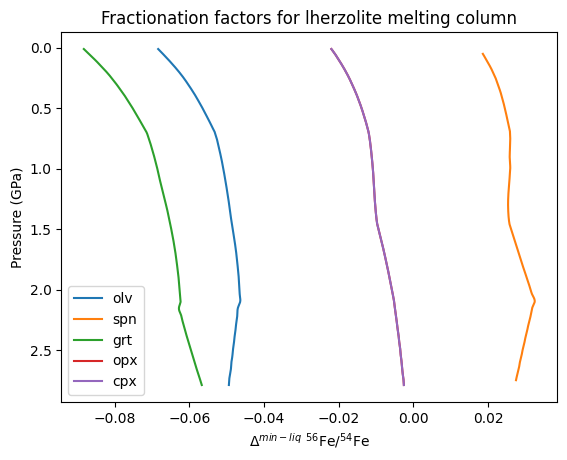

In [11]:
alpha = np.zeros([5, len(column.P)])
for i, row in column.composition['lz'].iterrows():
    alpha[0, i] = (olv_ff_56_54(row, lz.phaseDiagram))
    alpha[1, i] = (spn_ff_56_54(row, lz.phaseDiagram))
    alpha[2, i] = (grt_ff_56_54(row, lz.phaseDiagram))
    alpha[3, i] = (opx_ff_56_54(row, lz.phaseDiagram))
    alpha[4, i] = (cpx_ff_56_54(row, lz.phaseDiagram))

f, a = plt.subplots()

a.plot(alpha[0,:][alpha[0,:] != 0.0], column.P[alpha[0,:] != 0.0], label='olv')
a.plot(alpha[1,:][alpha[1,:] != 0.0], column.P[alpha[1,:] != 0.0], label='spn')
a.plot(alpha[2,:][alpha[2,:] != 0.0], column.P[alpha[2,:] != 0.0], label='grt')
a.plot(alpha[3,:][alpha[3,:] != 0.0], column.P[alpha[3,:] != 0.0], label='opx')
a.plot(alpha[3,:][alpha[4,:] != 0.0], column.P[alpha[4,:] != 0.0], label='cpx')

a.invert_yaxis()

a.set_ylabel('Pressure (GPa)')
a.set_xlabel(r'$\Delta^{min-liq}$ $^{56}$Fe/$^{54}$Fe')


# a.xaxis.set_major_formatter("{x:.6f}")

a.set_title("Fractionation factors for lherzolite melting column")

a.legend()

plt.show()

## 5. Do stable isotope calculation

Now we need to feed all of this information to pyMelt, along with the bulk composition of each mantle component. 

For the bulk composition, we will follow Soderman et al. (2021) and use:

In [12]:
d56_lz = 0.05 / 1.5
d56_px = 0.15 / 1.5

Now we feed this information in:

In [13]:
column.calculateStableIsotopes(species=['FeO', 'Fe2O3'],
                               fractionationFactors={'olv': olv_ff_56_54,
                                                     'opx': opx_ff_56_54,
                                                     'cpx': cpx_ff_56_54,
                                                     'grt': grt_ff_56_54,
                                                     'spn': spn_ff_56_54,
                                                     'plg': 1.0},
                                isotopeRatioLabel='d56Fe', # The label to be used in the results table
                                bulk={'lz': d56_lz,
                                      'px': d56_px},
                                fractionalExtraction= False, # Can approximate fractional extraction of melts by setting to True
                                porosity= 0.0 # Can do continueous melting (when fractional extraction enabled) by defining a porosity
                                )

/Users/sm905/repos/pyMelt/pyMelt/meltingcolumn_classes.py:456: UserWarning: Isotope ratios for solid phases where their phase fraction goes < 0.01 are masked as a temporary fix to problematic imports.
  _warnings.warn("Isotope ratios for solid phases where their phase fraction "


And we can look at the results:

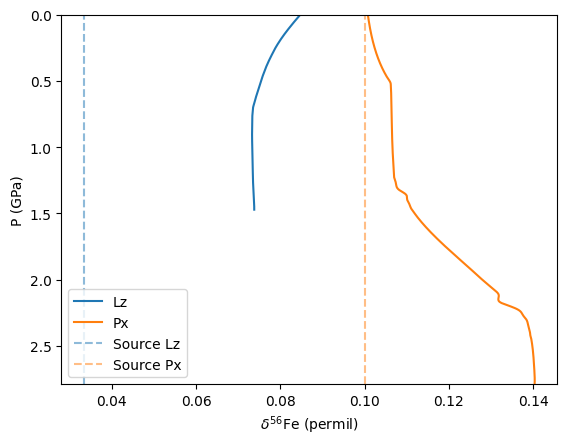

In [14]:
f, a = plt.subplots()

a.plot(column.composition['lz']['liq_d56Fe'], column.P, label='Lz')
a.plot(column.composition['px']['liq_d56Fe'], column.P, label='Px')

a.axvline(d56_lz, c='C0', alpha=0.5, ls='--', label='Source Lz')
a.axvline(d56_px, c='C1', alpha=0.5, ls='--', label='Source Px')


a.set_ylim(np.nanmax(column.P), 0)

a.set_xlabel("$\delta^{56}$Fe (permil)")
a.set_ylabel("P (GPa)")

a.legend(loc='lower left')

plt.show()

We can also see how the solid residue changes in composition throughout melting:

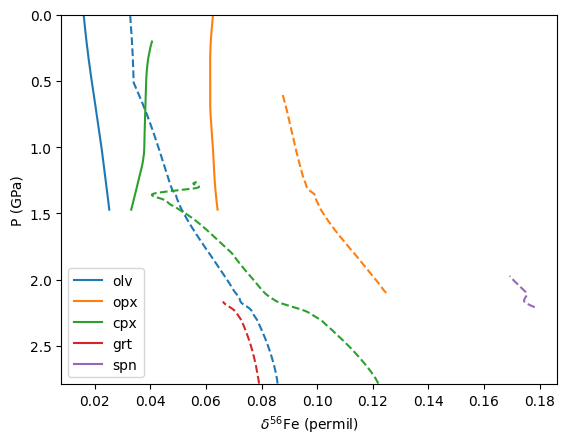

In [15]:
f, a = plt.subplots()

colours = {'olv': 'C0', 'opx': 'C1', 'cpx': 'C2', 'grt': 'C3', 'spn':'C4'}

for min in ['olv', 'opx', 'cpx', 'grt','spn']:

    a.plot(column.composition['lz'][min+'_d56Fe'], column.P, label=min, c=colours[min])
    a.plot(column.composition['px'][min+'_d56Fe'], column.P, ls='--', c=colours[min])

a.set_ylim(np.nanmax(column.P), 0)

a.set_xlabel("$\delta^{56}$Fe (permil)")
a.set_ylabel("P (GPa)")

a.legend(loc='lower left')

plt.show()

## 6. Find the aggregated melt composition
For this calculation we will assume we are at a mid-ocean ridge. See other templates for OIB melting.

We have to create a geosetting from the melting column. In doing this, pyMelt will calculate the crustal thickness (and therefore the depth at which melting should terminate) as well as calculating the weighting for each melt batch, assuming a triangular melting region.

In [16]:
mor = m.geosettings.spreadingCentre(column)

Find the aggregated $\delta^{56}$Fe:

In [17]:
mor.chemistry.liq_d56Fe

0.0955559012323621

## 7. What next?

The purpose of this template is to set out how to get results for Fe stable isotope fractionation only. It is likely you will also want to calculate other things, e.g., the trace element composition, or the radiogenic isotope ratios of the homogenized melt. Perhaps you want this as a function of $T_p$, mantle composition, or geodynamic setting. All of this is possible, but will require combining the code from different templates.

## References

Matthews, S., Wong, K., Shorttle, O., Edmonds, M., & Maclennan, J. (2021). Do olivine crystallization temperatures faithfully record mantle temperature variability? Geochemistry, Geophysics, Geosystems, 22, e2020GC009157. https://doi.org/10.1029/2020GC009157

Soderman, C. R., Matthews, S., Shorttle, O., Jackson, M. G., Ruttor, S., Nebel, O., Turner, S., Beier, C. Millet, M., Widom, E., Humayun, M., & Williams, H. M. (2021). Heavy δ57Fe in ocean island basalts: A non-unique signature of processes and source lithologies in the mantle, Geochimica et Cosmochimica Acta, 292, 309-332, https://doi.org/10.1016/j.gca.2020.09.033

Sossi, P. A., & O’Neill, H. S. C. (2017). The effect of bonding environment on iron isotope fractionation between minerals at high temperature. Geochimica et Cosmochimica Acta, 196, 121-143. https://doi.org/10.1016/j.gca.2016.09.017

Williams H. M., Matthews, S., Rizo, H., & Shorttle, O. (2021). Iron isotopes trace primordial magma ocean cumulates melting in Earth’s upper mantle. Sci. Adv. 7, eabc7394(2021). https://doi.org/10.1126/sciadv.abc7394